<a href="https://colab.research.google.com/github/panda1835/youtube-hunting/blob/main/04-Data-Analysis/01_video-content-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# download utilized scripts
!wget --no-cache https://raw.githubusercontent.com/panda1835/youtube-hunting/main/Utils/utils.py
!wget --no-cache https://raw.githubusercontent.com/panda1835/youtube-hunting/main/04-Data-Analysis/src/data_analysis_utils.py

--2022-01-03 10:21:48--  https://raw.githubusercontent.com/panda1835/youtube-hunting/main/Utils/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 992 [text/plain]
Saving to: ‘utils.py.13’

utils.py.13         100%[===================>]     992  --.-KB/s    in 0s      

2022-01-03 10:21:48 (59.9 MB/s) - ‘utils.py.13’ saved [992/992]

--2022-01-03 10:21:48--  https://raw.githubusercontent.com/panda1835/youtube-hunting/main/04-Data-Analysis/src/data_analysis_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3307 (3.2K) 

In [3]:
import pandas as pd
import numpy as np
import json 
import os
from tqdm import tqdm
import importlib
from time import sleep 
import scipy.stats as st

import matplotlib.pyplot as plt

# import utilized scripts
import utils as utils
import data_analysis_utils as dautils

In [36]:
importlib.reload(utils)
importlib.reload(dautils)

<module 'data_analysis_utils' from '/content/data_analysis_utils.py'>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
root = "/content/drive/My Drive/Let-Hunt-Youtube/"
config_file_path = os.path.join(root, 'config.json')

config = json.load(open(config_file_path))

database_save_folder = config['folder']['database']
visualization_save_folder = config['folder']['data-analysis']
visualization_content_save_folder = config['folder']['data-analysis-content']

# video_url_db_50_file_name = config['database']['video_url_50']
video_url_db_50_file_name = "VIDEO_URL_50_ADD_DISLIKE.csv"
video_url_db_50_annotation_file_name = config['database']['video_url_50_annotation']

video_url_db_50_file_path = os.path.join(root, database_save_folder, video_url_db_50_file_name)
video_url_db_50_annotation_file_path = os.path.join(root, database_save_folder, video_url_db_50_annotation_file_name)
visualization_folder_path = os.path.join(root, visualization_save_folder, visualization_content_save_folder)

In [6]:
# read db
video_df = pd.read_csv(video_url_db_50_file_path)
video_anno_df = pd.read_csv(video_url_db_50_annotation_file_path)

In [7]:
# create a join dataframe
data = video_anno_df.join(video_df, lsuffix='', rsuffix='other')
assert data.video_url.to_list() == data.video_urlother.to_list(), print("Unmatched id")
data.sample()

,video_url,comment_sheet_name,seller_showcase_only,seller_showcase_with_dead_animal,seller_demo_no_killing,seller_demo_has_killing,non_seller_has_killing,non_seller_no_killing,rifle_type,accessories,Note,video_urlother,num_dislike,added_date,search_query,video_file_name,channel_name,channel_url,extracted_date,video_id,comment_sheet_nameother,comment_added_date,video_name,id,video_url_other,channel_id,channel_name_other,video_file_name_other,video_description,num_like,num_dislike.1,num_view,published_time,tags,video_topic_category,duration,projection,definition,thumbnail_default,thumbnail_medium,thumbnail_high,thumbnail_standard,last_update
21,https://www.youtube.com/watch?v=uw7q-zS4Epc,video00022,x,NaN,NaN,NaN,NaN,NaN,NaN,ống nhắm,NaN,https://www.youtube.com/watch?v=uw7q-zS4Epc,2,2021-12-22 9:30:56,channel: PCP Duy anh,NaN,PCP Duy anh,https://www.youtube.com/channel/UCiishMm18Stfx...,NaN,uw7q-zS4Epc,video00022,2021-12-22 11:26:55,Hạ giá ống ngắm discovery vt1 đủ 3 thông số 3-...,uw7q-zS4Epc,https://www.youtube.com/watch?v=uw7q-zS4Epc,UCiishMm18StfxJCbo78umzw,PCP Duy anh,NaN,NaN,3,NaN,784,2019-05-09T08:11:47Z,NaN,https://en.wikipedia.org/wiki/Lifestyle_(socio...,PT6M21S,rectangular,hd,https://i.ytimg.com/vi/uw7q-zS4Epc/default.jpg,https://i.ytimg.com/vi/uw7q-zS4Epc/mqdefault.jpg,https://i.ytimg.com/vi/uw7q-zS4Epc/hqdefault.jpg,NaN,2021-12-31 15:28:46


In [8]:
# clean
# drop unnecessary column
data = data.drop(columns=['comment_sheet_name', 
                  'Note', 
                  'video_url_other', 
                  'added_date',
                  'search_query',
                  'video_file_name',
                  'channel_name',
                  'channel_url',
                  'extracted_date',
                  'comment_sheet_nameother',
                  'comment_added_date',
                  'id',
                  'video_url_other',
                  'channel_name_other',
                  'video_file_name_other',
                  'projection',
                  'definition',
                  'thumbnail_default',
                  'thumbnail_medium',
                  'thumbnail_high',
                  'thumbnail_standard',
                  'last_update'
                  ], axis=1)
# convert to date-time
data['published_time']=pd.to_datetime(data['published_time'])

In [9]:
data.columns

Index(['video_url', 'seller_showcase_only', 'seller_showcase_with_dead_animal',
       'seller_demo_no_killing', 'seller_demo_has_killing',
       'non_seller_has_killing', 'non_seller_no_killing', 'rifle_type',
       'accessories', 'video_urlother', 'num_dislike', 'video_id',
       'video_name', 'channel_id', 'video_description', 'num_like',
       'num_dislike.1', 'num_view', 'published_time', 'tags',
       'video_topic_category', 'duration'],
      dtype='object')

In [10]:
category = {
    'seller': [
      'seller_showcase_only', 
      'seller_showcase_with_dead_animal', 
      'seller_demo_no_killing',
      'seller_demo_has_killing'
    ],

    'non-seller': [
      'non_seller_has_killing',
      'non_seller_no_killing'                   
    ],

    'killing' : [
      'seller_demo_has_killing',
      'non_seller_has_killing'
    ],

    'non-killing' : [
      'seller_demo_no_killing',
      'non_seller_no_killing'
    ]
}

name_matching = {
    'seller_showcase_only' : 'showcase',
    'seller_showcase_with_dead_animal' : '',
    'seller_demo_no_killing' : '',
    'seller_demo_has_killing' : 'demo with killing',
    'non_seller_has_killing' : '',
    'non_seller_no_killing' : ''
}

frequency = data.count()

In [11]:
frequency

video_url                           50
seller_showcase_only                26
seller_showcase_with_dead_animal     1
seller_demo_no_killing               5
seller_demo_has_killing             10
non_seller_has_killing               3
non_seller_no_killing                3
rifle_type                          25
accessories                         20
video_urlother                      50
num_dislike                         50
video_id                            50
video_name                          50
channel_id                          50
video_description                   38
num_like                            50
num_dislike.1                        0
num_view                            50
published_time                      50
tags                                28
video_topic_category                49
duration                            50
dtype: int64

File is saved to seller_non_seller_content.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/seller_non_seller_content.jpg


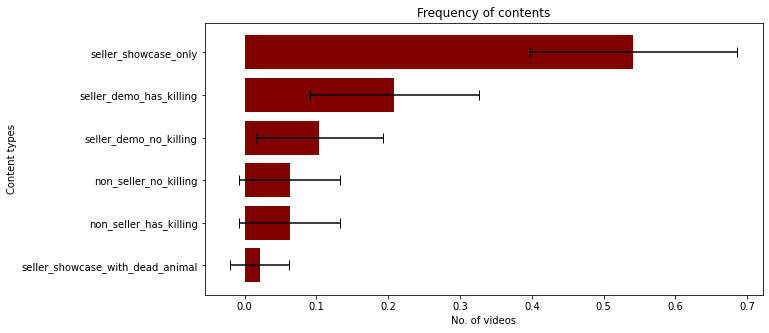

In [12]:
# bar plot of seller / non-seller contents
content_type_data = []

for i in ['seller_showcase_only', 
          'seller_showcase_with_dead_animal', 
          'seller_demo_no_killing',
          'seller_demo_has_killing',
          'non_seller_has_killing',
          'non_seller_no_killing'
          ]:
  content_type_data += [i for _ in range(frequency[i])]

plt = dautils.bar_plot(
    data=content_type_data,
    xlabel="No. of videos",
    ylabel="Content types",
    title="Frequency of contents",
    orientation='horizontal',
    frequency=True,
    confidence_interval=("proportion", 0.95)
)

# save image
utils.save_image(plt, visualization_folder_path, "seller_non_seller_content.jpg")

File is saved to seller_non_seller_frequency.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/seller_non_seller_frequency.jpg


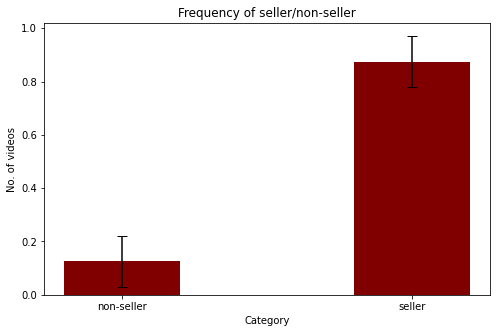

In [13]:
# seller/non-seller
seller_non_seller_data = []
seller_non_seller_data += ['seller' for _ in range(frequency[category['seller']].sum())]
seller_non_seller_data += ['non-seller' for _ in range(frequency[category['non-seller']].sum())]

plt = dautils.bar_plot(
    data=seller_non_seller_data,
    xlabel="Category",
    ylabel="No. of videos",
    title="Frequency of seller/non-seller",
    figsize=(8,5),
    frequency=True,
    confidence_interval=("proportion", 0.95)
)

# save image
utils.save_image(plt, visualization_folder_path, "seller_non_seller_frequency.jpg")

File is saved to killing_non_killing_frequency.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/killing_non_killing_frequency.jpg


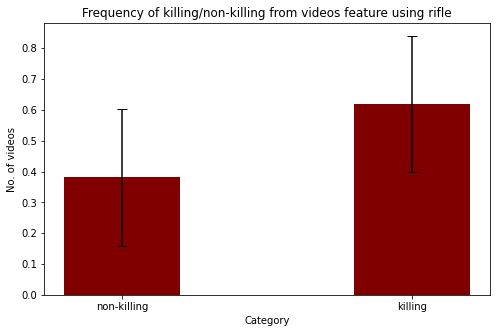

In [15]:
# killing / non-killing
killing_non_killing_data = []
killing_non_killing_data += ['killing' for _ in range(frequency[category['killing']].sum())]
killing_non_killing_data += ['non-killing' for _ in range(frequency[category['non-killing']].sum())]

plt = dautils.bar_plot(
    data=killing_non_killing_data,
    xlabel="Category",
    ylabel="No. of videos",
    title="Frequency of killing/non-killing from videos feature using rifle",
    figsize=(8,5),
    frequency=True,
    confidence_interval=("proportion", 0.95)
)

# save image
utils.save_image(plt, visualization_folder_path, "killing_non_killing_frequency.jpg")

File is saved to rifle_type_frequency.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/rifle_type_frequency.jpg


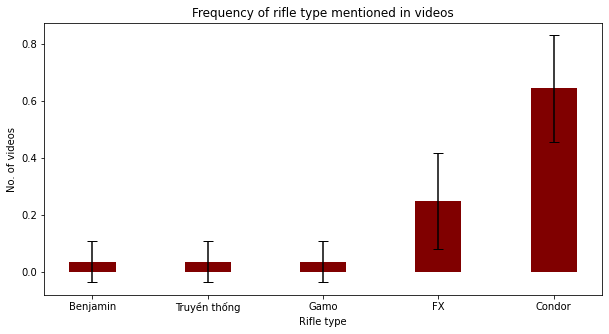

In [38]:
rifle_type_list = []
for i in data.rifle_type[data.rifle_type.notna()]:
  rifle_type_list += i.split(', ')

rifle_type_list = [s.strip() for s in rifle_type_list]

plt = dautils.bar_plot(
    data=rifle_type_list,
    xlabel="Rifle type",
    ylabel="No. of videos",
    title="Frequency of rifle type mentioned in videos",
    frequency=True,
    confidence_interval=("proportion", 0.95)
)

# save image
utils.save_image(plt, visualization_folder_path, "rifle_type_frequency.jpg")

File is saved to trend-over-time-by-month.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/trend-over-time-by-month.jpg


<Figure size 720x360 with 0 Axes>

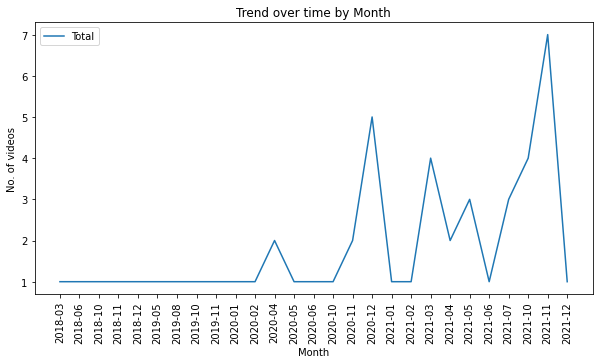

In [55]:
# trend over time by Month
a = data.groupby(data['published_time'].dt.strftime('%Y-%m'))['video_url'].count()
x = a.index

plt = dautils.trend_plot(
    {
        'Total':{
            'x': x,
            'y': a[x]
        }
    }, 
    xlabel='Month', 
    ylabel='No. of videos',
    title='Trend over time by Month',
    xrotation=90
  )
utils.save_image(plt, visualization_folder_path, "trend-over-time-by-month.jpg")

File is saved to trend-over-time-by-year.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/trend-over-time-by-year.jpg


<Figure size 720x360 with 0 Axes>

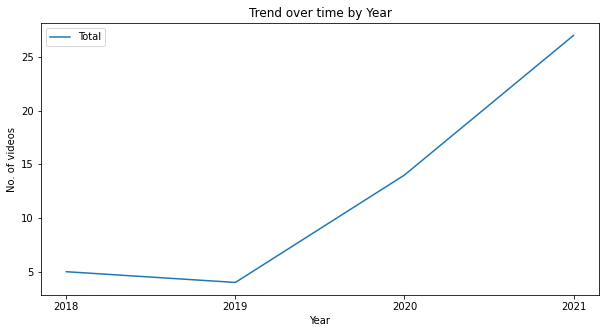

In [51]:
# trend over time by Year
a = data.groupby(data['published_time'].dt.strftime('%Y'))['video_url'].count()
x = a.index

plt = dautils.trend_plot(
    {
        'Total':{
            'x': x,
            'y': a[x]
        }
    }, 
    xlabel='Year', 
    ylabel='No. of videos',
    title='Trend over time by Year'
  )
utils.save_image(plt, visualization_folder_path, "trend-over-time-by-year.jpg")

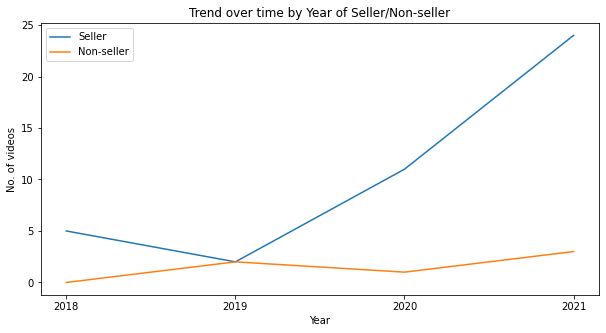

In [75]:
# trend of each seller/non-seller
seller = data[category['seller']].groupby(data['published_time'].dt.strftime('%Y')).count().sum(axis=1)
x_seller = seller.index

non_seller = data[category['non-seller']].groupby(data['published_time'].dt.strftime('%Y')).count().sum(axis=1)
x_non_seller = non_seller.index

plt = dautils.trend_plot(
    {
        'Seller':{
            'x': x_seller,
            'y': seller[x_seller]
        },
        'Non-seller':{
            'x': x_non_seller,
            'y': non_seller[x_non_seller]
        }
    }, 
    xlabel='Year', 
    ylabel='No. of videos',
    title='Trend over time by Year of Seller/Non-seller'
  )
# utils.save_image(plt, visualization_folder_path, "trend-over-time-by-seller-non-seller.jpg")

File is saved to trend-over-time-by-killing-non-killing.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/trend-over-time-by-killing-non-killing.jpg


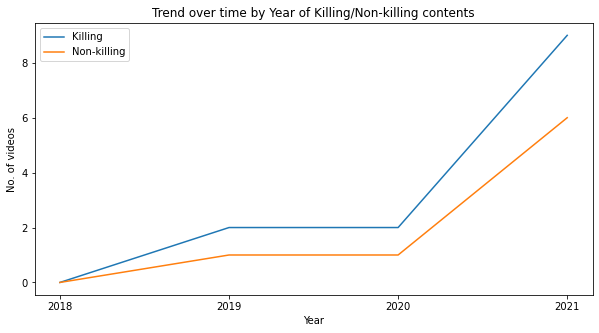

In [73]:
# trend of each killing/non-killing content
killing = data[category['killing']].groupby(data['published_time'].dt.strftime('%Y')).count().sum(axis=1)
x_killing = seller.index

non_killing = data[category['non-killing']].groupby(data['published_time'].dt.strftime('%Y')).count().sum(axis=1)
x_non_killing = non_seller.index

plt = dautils.trend_plot(
    {
        'Killing':{
            'x': x_killing,
            'y': killing[x_killing]
        },
        'Non-killing':{
            'x': x_non_killing,
            'y': non_killing[x_non_killing]
        }
    }, 
    xlabel='Year', 
    ylabel='No. of videos',
    title='Trend over time by Year of Killing/Non-killing contents'
  )
# utils.save_image(plt, visualization_folder_path, "trend-over-time-by-killing-non-killing.jpg")

File is saved to topic_category_pie.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/topic_category_pie.jpg


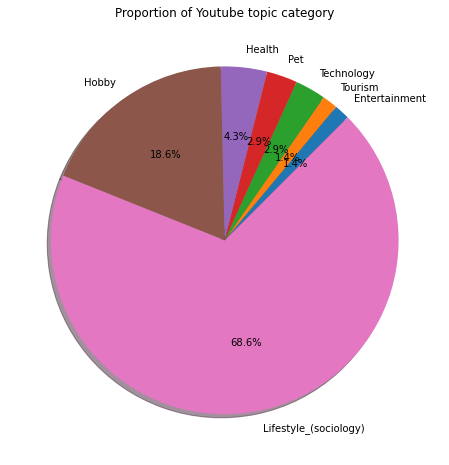

In [22]:
# tag
topic_list_with_wiki = []

for i in data['video_topic_category'].to_list():
  if str(i) != 'nan':
    topic_list_with_wiki += i.split(', ')
topic_list = []
for i in topic_list_with_wiki:
  topic_list.append(i.split('/')[-1])

topic_freq = dautils.list_to_freq(topic_list)
topic_label = []
topic_value = []

for topic in topic_freq.keys():
  topic_label.append(topic)
  topic_value.append(topic_freq[topic])

plt.figure(figsize=(8,8))
plt.pie(topic_value, labels=topic_label, autopct='%1.1f%%', shadow=True, startangle=45)
plt.title('Proportion of Youtube topic category')

# utils.save_image(plt, visualization_folder_path, "topic_category_pie.jpg")

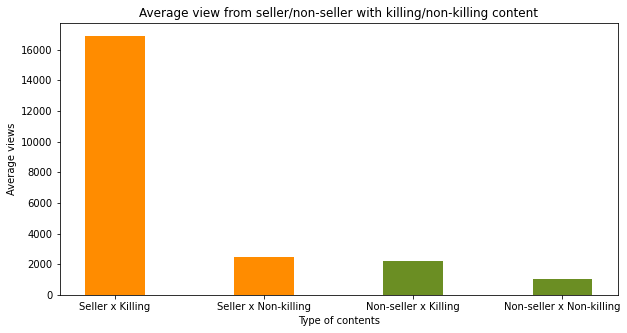

In [37]:
# average view by category
def mean_metadata_of_intersection(A, B, metadata):
  C = list(set(category[A]).intersection(set(category[B])))
  C_num_view_mean = round(data[C + [metadata]].dropna(subset=C, how='all')[metadata].mean())
  return C_num_view_mean

seller_killing_num_view_mean         = mean_metadata_of_intersection('seller', 'killing', 'num_view')
seller_non_killing_num_view_mean     = mean_metadata_of_intersection('seller', 'non-killing', 'num_view')
non_seller_killing_num_view_mean     = mean_metadata_of_intersection('non-seller', 'killing', 'num_view')
non_seller_non_killing_num_view_mean = mean_metadata_of_intersection('non-seller', 'non-killing', 'num_view')

plt = dautils.bar_plot(
    data={
        "Seller x Killing": seller_killing_num_view_mean,
        "Seller x Non-killing": seller_non_killing_num_view_mean,
        "Non-seller x Killing": non_seller_killing_num_view_mean,
        "Non-seller x Non-killing": non_seller_non_killing_num_view_mean
    },
    xlabel="Type of contents",
    ylabel="Average views",
    title="Average view from seller/non-seller with killing/non-killing content",
    color=['darkorange', 'darkorange', 'olivedrab', 'olivedrab']
)

# save image
utils.save_image(plt, visualization_folder_path, "avg-view-seller-non-seller-killing-non-killing.jpg")

File is saved to avg-like-seller-non-seller-killing-non-killing.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/avg-like-seller-non-seller-killing-non-killing.jpg


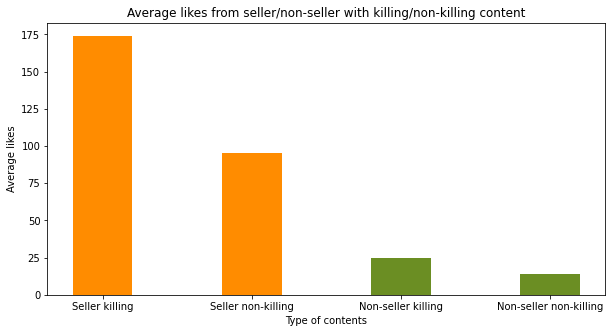

In [40]:
# average like by category
seller_killing_num_like_mean         = mean_metadata_of_intersection('seller', 'killing', 'num_like')
seller_non_killing_num_like_mean     = mean_metadata_of_intersection('seller', 'non-killing', 'num_like')
non_seller_killing_num_like_mean     = mean_metadata_of_intersection('non-seller', 'killing', 'num_like')
non_seller_non_killing_num_like_mean = mean_metadata_of_intersection('non-seller', 'non-killing', 'num_like')

plt = dautils.bar_plot(
    data={
        "Seller killing": seller_killing_num_like_mean,
        "Seller non-killing": seller_non_killing_num_like_mean,
        "Non-seller killing": non_seller_killing_num_like_mean,
        "Non-seller non-killing": non_seller_non_killing_num_like_mean
    },
    xlabel="Type of contents",
    ylabel="Average likes",
    title="Average likes from seller/non-seller with killing/non-killing content",
    # value_annotation=False,
    color=['darkorange', 'darkorange', 'olivedrab', 'olivedrab']
)

# save image
utils.save_image(plt, visualization_folder_path, "avg-like-seller-non-seller-killing-non-killing.jpg")

File is saved to avg-dislike-seller-non-seller-killing-non-killing.jpg in Google Drive at /content/drive/My Drive/Let-Hunt-Youtube/Data-Analysis/Content/avg-dislike-seller-non-seller-killing-non-killing.jpg


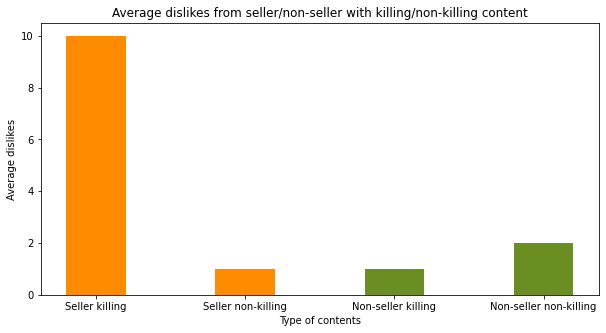

In [42]:

seller_killing_num_dislike_mean         = mean_metadata_of_intersection('seller', 'killing', 'num_dislike')
seller_non_killing_num_dislike_mean     = mean_metadata_of_intersection('seller', 'non-killing', 'num_dislike')
non_seller_killing_num_dislike_mean     = mean_metadata_of_intersection('non-seller', 'killing', 'num_dislike')
non_seller_non_killing_num_dislike_mean = mean_metadata_of_intersection('non-seller', 'non-killing', 'num_dislike')

plt = dautils.bar_plot(
    data={
        "Seller killing": seller_killing_num_dislike_mean,
        "Seller non-killing": seller_non_killing_num_dislike_mean,
        "Non-seller killing": non_seller_killing_num_dislike_mean,
        "Non-seller non-killing": non_seller_non_killing_num_dislike_mean
    },
    xlabel="Type of contents",
    ylabel="Average dislikes",
    title="Average dislikes from seller/non-seller with killing/non-killing content",
    # value_annotation=False,
    color=['darkorange', 'darkorange', 'olivedrab', 'olivedrab']
)

# save image
utils.save_image(plt, visualization_folder_path, "avg-dislike-seller-non-seller-killing-non-killing.jpg")

In [ ]:
plot_df = pd.DataFrame({
    'type': [
             "Seller killing",
             "Seller non-killing",
             "Non-seller killing",
             "Non-seller non-killing"
    ],
    'num-like': [
                 seller_killing_num_like_mean,
                 seller_non_killing_num_like_mean,
                 non_seller_killing_num_like_mean,
                 non_seller_non_killing_num_like_mean
    ],
    'num-dislike': [
                    seller_killing_num_dislike_mean,
                    seller_non_killing_num_dislike_mean,
                    non_seller_killing_num_dislike_mean,
                    non_seller_non_killing_num_dislike_mean
    ]
}).plot(x="type", y=["num-like", "num-dislike"], kind="bar",figsize=(9,8))